## BE485, Lab 10, Ex 2
 In this exercise:<br>
 a) Read Different datatype layers<br>
    - Continuous dataset (NDVI)<br>
    - Discrete/Thematic dataset  (RANK) <br>
 b) resample dataset using<br>
    - Nearest neighborhs (NN)<br>
    - Bilinear<br>
    - Cubic convolution<br>
    - Majority<br>
    going from 1km to 3km pixelsize <br>
 c) display each output<br>
    - RANK bands using a custom color LUT <br>
 d) compare pixel values from each method
    

    

In [1]:
#Needs to be done only once
import sys
!conda install --yes --prefix {sys.prefix} hdf4

^C


In [2]:
#Needs to be done only once
import sys
!conda install --yes --prefix {sys.prefix} conda-forge pyhdf

^C


In [5]:
# Import all necessary libraries

import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np

# Library for reading HDF files
from pyhdf.SD import SD, SDC


#Import the VIP Library
import viplab_lib5 as vip

# This is a magic function call that renders the figure in a notebook
# instead of displaying a dump of the figure object
%matplotlib inline


# user defined functions

In [6]:
# user defined functions

# user defined function to resample using nearest neighbors
def resample_nn(data):
    #get size of input band
    nrowsIN,ncolsIN=data.shape
    #calculate output band size
    nrows=nrowsIN // 3
    ncols=ncolsIN // 3
    
    #create empty band
    datares=np.zeros((nrows,ncols))
    for i in range(0,nrows):
        for j in range(0,ncols):
            #calculate row at input band
            rowIN=(i*3)+1
            #check for out of boundary row
            if(rowIN<0):
                rowIN=0
            elif (rowIN>nrowsIN-1):
                rowIN=nrowsIN-1
                
            #calculate col at input band    
            colIN=(j*3)+1
            #check for out of boundary column
            if(colIN<0):
                colIN=0
            elif (colIN>ncolsIN-1):
                colIN=nrowsIN-1
                
            #assign pixel from input band to output    
            datares[i,j]=data[rowIN,colIN]
    return datares

def resample_bilinear(data):
    #get size of input band
    nrowsIN,ncolsIN=data.shape
    #calculate output band size
    nrows=nrowsIN // 3
    ncols=ncolsIN // 3
    
    #create empty band
    datares=np.zeros((nrows,ncols))
    for i in range(0,nrows):
        for j in range(0,ncols):
            #calculate row at input band
            rowIni=i*3

            #calculate col at input band    
            colIni=j*3

            sum=0
            counter=0
            #loop a 2x2 box at the initial row/col 
            for r in range(0,2):
                for c in range(0,2):
                    rowIN=rowIni+r
                    colIN=colIni+c
                    
                    if(rowIN>=0 and rowIN<nrowsIN):
                        if(colIN>=0 and colIN<ncolsIN):
                            sum=sum+data[rowIN,colIN]
                            counter=counter+1
                            
            #assign pixel from input band to output
            if(counter>0):
                value=sum/counter
            else:
                value=-15000
                
            datares[i,j]=value
    
    return datares


def resample_cubic(data):
    #get size of input band
    nrowsIN,ncolsIN=data.shape
    #calculate output band size (integer)
    nrows=nrowsIN // 3
    ncols=ncolsIN // 3
    
    #create empty band
    datares=np.zeros((nrows,ncols))
    for i in range(0,nrows):
        for j in range(0,ncols):
            #calculate row at input band
            rowIni=i*3+1

            #calculate col at input band    
            colIni=j*3+1

            sum=0
            counter=0
            #loop a 4x4 box at the center row/col 
            for r in range(0,5):
                for c in range(0,5):
                    rowIN=rowIni+r-3
                    colIN=colIni+c-3
                    
                    if(rowIN>=0 and rowIN<nrowsIN):
                        if(colIN>=0 and colIN<ncolsIN):
                            sum=sum+data[rowIN,colIN]
                            counter=counter+1
                            
            #assign pixel from input band to output
            if(counter>0):
                value=sum/counter
            else:
                value=-15000
                
            datares[i,j]=value
    return datares


# obtains the majority value from a list of values
def majority_get(list):
    #return unique list, and counts for each value
    uniquelist,counts=np.unique(list,return_counts=True)
    #obtains the index of the max
    idmax=np.argmax(counts)
    value=uniquelist[idmax]
    return value


def resample_majority(data):
    #get size of input band
    nrowsIN,ncolsIN=data.shape
    #calculate output band size
    nrows=nrowsIN // 3
    ncols=ncolsIN // 3
    
    #create empty band
    datares=np.zeros((nrows,ncols))
    for i in range(0,nrows):
        for j in range(0,ncols):
            #calculate row at input band
            rowIni=i*3

            #calculate col at input band    
            colIni=j*3
            
            #initialize a list to compare values
            listValues=[]
            #loop a 3x3 box at the initial row/col 
            for r in range(0,3):
                for c in range(0,3):
                    rowIN=rowIni+r
                    colIN=colIni+c
                    
                    if(rowIN>=0 and rowIN<nrowsIN):
                        if(colIN>=0 and colIN<ncolsIN):
                          #add value to list
                          listValues.append(data[rowIN,colIN])
            
            #retrieve the value as majority from list    
            datares[i,j]=majority_get(listValues)
    
    return datares

## Main program starts here !
## 1. HDF4 basics

In [28]:
#filename to read
filename = './Data/MOD13A2.A2020065.h08v05.006.2020082012602.hdf'

# Open HDF file for reading
hdf = SD(filename, SDC.READ)

#Display Number of datasets (bands) in file
print("Number of datasets")
print(hdf.info())

# Get information about the datasets
bandsInfo=hdf.datasets();

#Displaying basic info
print("\nDatasets name, #rows, #cols, datatype, index")
for key in bandsInfo.keys():
  print(key, bandsInfo[key])

nrows=bandsInfo['1 km 16 days NDVI'][1][0]
ncols=bandsInfo['1 km 16 days NDVI'][1][1]
print(nrows,ncols)
#close hdf file
hdf.end()

Number of datasets
(12, 6)

Datasets name, #rows, #cols, datatype, index
1 km 16 days NDVI (('YDim:MODIS_Grid_16DAY_1km_VI', 'XDim:MODIS_Grid_16DAY_1km_VI'), (1200, 1200), 22, 0)
1 km 16 days EVI (('YDim:MODIS_Grid_16DAY_1km_VI', 'XDim:MODIS_Grid_16DAY_1km_VI'), (1200, 1200), 22, 1)
1 km 16 days VI Quality (('YDim:MODIS_Grid_16DAY_1km_VI', 'XDim:MODIS_Grid_16DAY_1km_VI'), (1200, 1200), 23, 2)
1 km 16 days red reflectance (('YDim:MODIS_Grid_16DAY_1km_VI', 'XDim:MODIS_Grid_16DAY_1km_VI'), (1200, 1200), 22, 3)
1 km 16 days NIR reflectance (('YDim:MODIS_Grid_16DAY_1km_VI', 'XDim:MODIS_Grid_16DAY_1km_VI'), (1200, 1200), 22, 4)
1 km 16 days blue reflectance (('YDim:MODIS_Grid_16DAY_1km_VI', 'XDim:MODIS_Grid_16DAY_1km_VI'), (1200, 1200), 22, 5)
1 km 16 days MIR reflectance (('YDim:MODIS_Grid_16DAY_1km_VI', 'XDim:MODIS_Grid_16DAY_1km_VI'), (1200, 1200), 22, 6)
1 km 16 days view zenith angle (('YDim:MODIS_Grid_16DAY_1km_VI', 'XDim:MODIS_Grid_16DAY_1km_VI'), (1200, 1200), 22, 7)
1 km 16 days sun

## Reading data from HDF4 file

In [29]:
# input data
#nrows=1200
#ncols=1200

# index: datatype : band name
#  0 : INT16  : 1 km 16 days NDVI
#  1 : INT16  : 1 km 16 days EVI
#  2 : UINT16 : 1 km 16 days VI Quality
#  3 : INT16  : 1 km 16 days red reflectance
#  4 : INT16  : 1 km 16 days NIR reflectance
#  5 : INT16  : 1 km 16 days blue reflectance
#  6 : INT16  : 1 km 16 days MIR reflectance
#  7 : INT16  : 1 km 16 days view zenith angle
#  8 : INT16  : 1 km 16 days sun zenith angle
#  9 : INT16  : 1 km 16 days relative azimuth angle
# 10 : INT16  : 1 km 16 days composite day of the year
# 11 :  INT8  : 1 km 16 days pixel reliability

print("Reading MODIS file ",filename)

hdf = SD(filename, SDC.READ)
sdsNDVI= hdf.select('1 km 16 days NDVI')
bandNDVI=sdsNDVI.get()
sdsRANK= hdf.select('1 km 16 days pixel reliability')
bandRANK=sdsRANK.get()
    
hdf.end()

Reading MODIS file  ./Data/MOD13A2.A2020065.h08v05.006.2020082012602.hdf


## 2. Display NDVI and RANK bands using a custom color table 

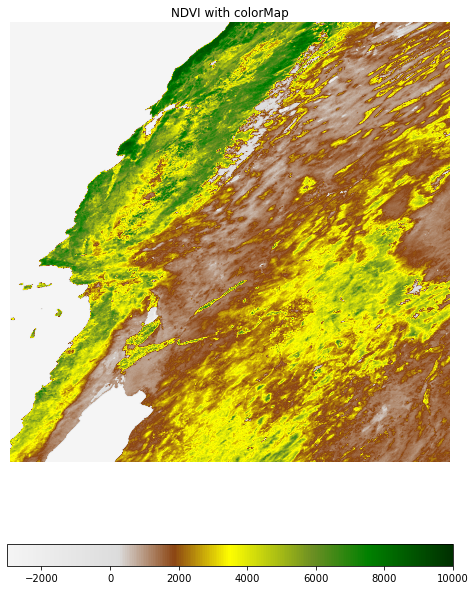

In [45]:
#Display input data using custom colors

# use NDVI custom color map
valueList  = [-0.6, -0.2, 0.,0.2, 0.5, 0.7, 1]  # Define the color nodes 
#colorList = ["whitesmoke","gainsboro","saddlebrown","yellow","olivedrab","green","#003000"]  # Define the colors for each node 
colorList = ["whitesmoke","gainsboro","saddlebrown","yellow","olivedrab","green","#003000"]  # Define the colors for each node 
cmapNDVI=vip.createColorMap([valueList,colorList],plt)

plt.figure(figsize=(10,10))
plt.imshow(bandNDVI, cmap=cmapNDVI)
plt.title("NDVI with colorMap")
plt.axis('off')

# Find width_of_image/height_of_image
im_ratio = bandNDVI.shape[1]/bandNDVI.shape[0]
 
# Plot horizontal colorbar
plt.colorbar(orientation="horizontal", fraction=0.041*im_ratio)
plt.show()

(-0.5, 1199.5, 1199.5, -0.5)

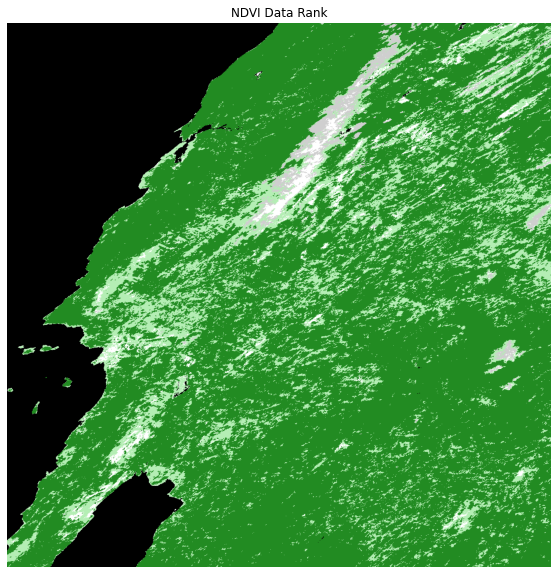

In [50]:
#Load a LUT color for RANK
RankLUT=vip.LUT_getdefault("RANK")
ImageLUT=vip.getImage_fromLUT(bandRANK,RankLUT)

plt.figure(figsize=(10,10))
plt.imshow(ImageLUT)
plt.title("NDVI Data Rank")

plt.axis('off')

## 3. Run resampling methods for both bands

In [51]:
print("Resampling... it may take sometime, wait")
Start=vip.startTime()

#Resample NDVI using all methods
bandNDVI_nn=resample_nn(bandNDVI)
bandNDVI_bilinear=resample_bilinear(bandNDVI)
bandNDVI_cubic=resample_cubic(bandNDVI)
bandNDVI_maj=resample_majority(bandNDVI)

#Resample RANK using all methods
bandRANK_nn=resample_nn(bandRANK)
bandRANK_bilinear=resample_bilinear(bandRANK)
bandRANK_cubic=resample_cubic(bandRANK)
bandRANK_maj=resample_majority(bandRANK)
vip.endTime(Start)

Resampling... it may take sometime, wait
 16.39  seconds


## 4. Extract pixel values for a couple of locations

In [52]:
#define location to extract data from 
pointlist=[[122,201],[64,255]]

for pixel in pointlist:
    row=pixel[0]
    col=pixel[1]

    pixelInput=bandNDVI[row*3+1,col*3+1]
    pixelNN=bandNDVI_nn[row,col]
    pixelBIL=bandNDVI_bilinear[row,col]
    pixelCUBIC=bandNDVI_cubic[row,col]
    pixelMAJ=bandNDVI_maj[row,col]

    print("\nThe pixel values for band [NDVI] at row=",row,", col=",col," are:")
    print("Input pixel=",pixelInput)
    print("Pixel NN=",pixelNN)
    print("Pixel Bilinear=",pixelBIL)
    print("Pixel Cubic=",pixelCUBIC)
    print("Pixel Majority=",pixelMAJ)


    pixelInput=bandRANK[row*3+1,col*3+1]
    pixelNN=bandRANK_nn[row,col]
    pixelBIL=bandRANK_bilinear[row,col]
    pixelCUBIC=bandRANK_cubic[row,col]
    pixelMAJ=bandRANK_maj[row,col]

    print("\nThe pixel values for band [RANK] at row=",row,", col=",col," are:")
    print("Input pixel=",pixelInput)
    print("Pixel NN=",pixelNN)
    print("Pixel Bilinear=",pixelBIL)
    print("Pixel Cubic=",pixelCUBIC)
    print("Pixel Majority=",pixelMAJ)


The pixel values for band [NDVI] at row= 122 , col= 201  are:
Input pixel= 2462
Pixel NN= 2462.0
Pixel Bilinear= 3137.0
Pixel Cubic= 3458.68
Pixel Majority= 1262.0

The pixel values for band [RANK] at row= 122 , col= 201  are:
Input pixel= 2
Pixel NN= 2.0
Pixel Bilinear= 1.5
Pixel Cubic= 1.36
Pixel Majority= 1.0

The pixel values for band [NDVI] at row= 64 , col= 255  are:
Input pixel= 2056
Pixel NN= 2056.0
Pixel Bilinear= 2105.0
Pixel Cubic= 1654.32
Pixel Majority= 6.0

The pixel values for band [RANK] at row= 64 , col= 255  are:
Input pixel= 0
Pixel NN= 0.0
Pixel Bilinear= 0.25
Pixel Cubic= 1.16
Pixel Majority= 0.0


## 5. Display images for each band per method

(-0.5, 399.5, 399.5, -0.5)

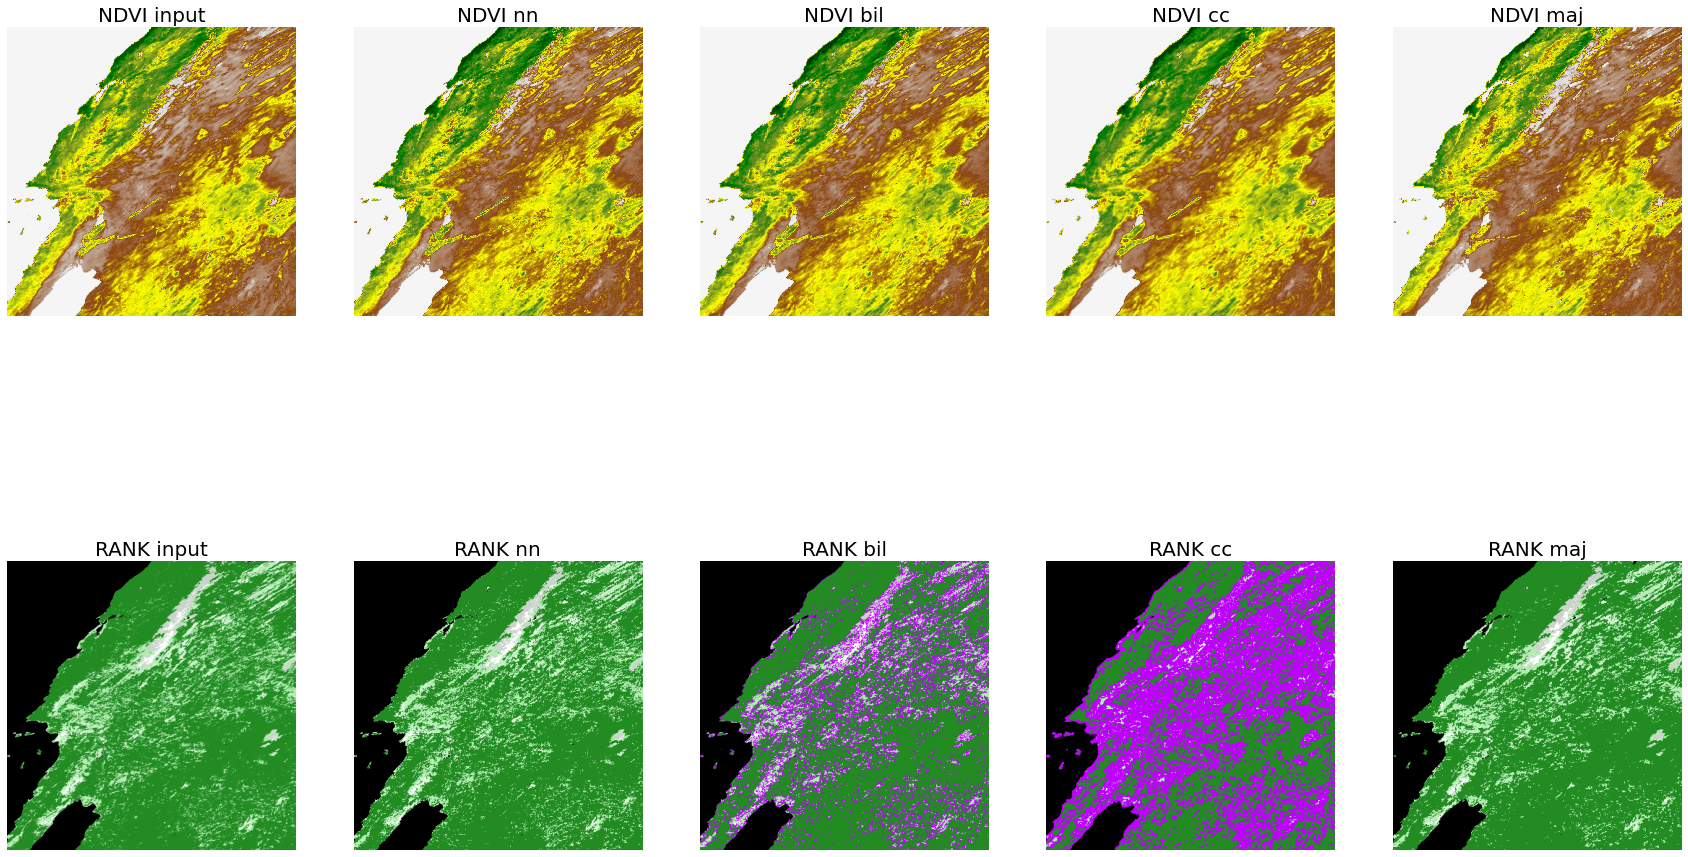

In [56]:
# Display layers for each method

#plt.figure(figsize=(30,18))
f, plot = plt.subplots(2, 5,figsize=(30,18) )

im=plot[0,0].imshow(bandNDVI, cmap=cmapNDVI)
plot[0,0].set_title("NDVI input",fontsize=20)
plot[0,0].axis('off')

im=plot[0,1].imshow(bandNDVI_nn, cmap=cmapNDVI)
plot[0,1].set_title("NDVI nn",fontsize=20)
plot[0,1].axis('off')


im=plot[0,2].imshow(bandNDVI_bilinear, cmap=cmapNDVI)
plot[0,2].set_title("NDVI bil",fontsize=20)
plot[0,2].axis('off')


im=plot[0,3].imshow(bandNDVI_cubic, cmap=cmapNDVI)
plot[0,3].set_title("NDVI cc",fontsize=20)
plot[0,3].axis('off')

im=plot[0,4].imshow(bandNDVI_maj, cmap=cmapNDVI)
plot[0,4].set_title("NDVI maj",fontsize=20)
plot[0,4].axis('off')



#display RANK band using a proper LUT color
ImageLUT=vip.getImage_fromLUT(bandRANK,RankLUT)
im=plot[1,0].imshow(ImageLUT, cmap='gray')
plot[1,0].set_title("RANK input",fontsize=20)
plot[1,0].axis('off')

ImageLUT=vip.getImage_fromLUT(bandRANK_nn,RankLUT)
im=plot[1,1].imshow(ImageLUT, cmap='gray')
plot[1,1].set_title("RANK nn",fontsize=20)
plot[1,1].axis('off')

ImageLUT=vip.getImage_fromLUT(bandRANK_bilinear,RankLUT)
im=plot[1,2].imshow(ImageLUT, cmap='gray')
plot[1,2].set_title("RANK bil",fontsize=20)
plot[1,2].axis('off')

ImageLUT=vip.getImage_fromLUT(bandRANK_cubic,RankLUT)
im=plot[1,3].imshow(ImageLUT, cmap='gray')
plot[1,3].set_title("RANK cc",fontsize=20)
plot[1,3].axis('off')

ImageLUT=vip.getImage_fromLUT(bandRANK_maj,RankLUT)
im=plot[1,4].imshow(ImageLUT, cmap='gray')
plot[1,4].set_title("RANK maj",fontsize=20)
plot[1,4].axis('off')


## <font color="red">6. Homework (see presentation)</font>

## a) Transect comparison




In [57]:
#put here your code to extract a transect (row or column) for all methods for NDVI and RANK
#create a plot (one for NDVI and one for RANK)

In [58]:
# Redo for CDOY

In [59]:
# explain what you see on the plots, when to use each method?, which one is better? Why?

## b) False color composite image from input dataset 

In [60]:
#put here you code to display a MIR-NIR-RED image

## c) Perform the same analysis on the CDOY

In [61]:
#Your code here

In [62]:
print("program ended.")

program ended.
